In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



dataset = 'FTSE'
data = pd.read_csv(f'data/{dataset}_wk_price.txt', sep="   ", header=None, engine='python')
columns = [f'Asset {i}' for i in range(data.shape[1])]
data.columns = columns
# index = [f'Week {i}' for i in range(data.shape[0])]
# data.index = index

# res = (prices/prices.shift(1) - 1.0)[1:]
returns = np.around(data/data.shift(1) - 1.0, 2)

# Code adjustments
ESTIMATION_START = round(data.shape[0]*1/3)
returns_in_sample = ((data - data.shift(1))/data.iloc[0]).iloc[:COLLECT_DATA_WEEKS_NUM]
returns_out_sample = ((data - data.shift(1))/data.iloc[COLLECT_DATA_WEEKS_NUM-1]).iloc[COLLECT_DATA_WEEKS_NUM:]
pd.concat([returns_in_sample, returns_out_sample])

In [ ]:
d = pd.DataFrame({'col1': [1, 2, 3, 4], 'col2': [5, 6, 7, 8]})
a = d.iloc[0].to_numpy().copy()
a[0] = 999
d


In [ ]:
import numpy as np
import pandas as pd
import argparse
from pymongo import MongoClient
from matplotlib import pyplot as plt


client = MongoClient(host="localhost", port=27017)
db = client.cno
runs = db.runs

dataset = 'FTSE'
data = pd.read_csv(f'data/{dataset}_wk_price.txt', sep="   ", header=None, engine='python')
columns = [f'Asset {i}' for i in range(data.shape[1])]
data.columns = columns
index = [f'Week {i}' for i in range(data.shape[0])]
data.index = index

returns = np.log(data/data.shift(1))

mu_array = returns.expanding().mean()
sigma_array = returns.expanding().cov()

fig = plt.figure(figsize=(15, 30))
gs = fig.add_gridspec(10, 1)

for i in range(1, 10):
    
    C = sigma_array.loc[f"Week {i*100}"].to_numpy().copy()
    w, v = np.linalg.eig(C)
    p = v[:,0]/v[:,0].sum()
    print(p.sum(), '\n', p, '\n\n')
    # all(C@v[:,0] - w[0]*v[:,0] < 1e-8)

    ax = fig.add_subplot(gs[i])
    ax.set_title(f'Week {i*100}')

    ax.eventplot(w, orientation='horizontal', colors='black', linewidths=0.5)
    ax.get_yaxis().set_visible(False)
    ax.axhline(y=1, color='gray', linestyle='--')
    ax.set_xlim([0, 0.08])
    ax.grid()
fig.savefig('results/covariation_eigenvalues.jpg')

In [ ]:
print(v[:,0])
# z1 = v[:,0] @ returns.loc[f"Week 100"]
# returns.loc[f"Week 100"]

## Index Sharpe Ratio

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dataset = "HDAX"
partition = 1/2
ESTIMATION_END = 938
ANNUAL_MULTIPLIER = np.sqrt(938/18)

if partition == 1/3:
    ESTIMATION_START = 313
elif partition == 1/2:
    ESTIMATION_START = 469
elif partition == 2/3:
    ESTIMATION_START = 625
 
index_data = pd.read_csv(f'data/{dataset}_historical_index.txt', header=None, engine='python')[0]
RISK_FREE = pd.read_csv(f'data/rf_00_17.txt', header=None, engine='python').T[0]
index_returns = ((index_data / index_data.shift(1)) - 1.0).shift(-1)
index_returns = index_returns.iloc[ESTIMATION_START:ESTIMATION_END]
excess_index_returns = index_returns - RISK_FREE.iloc[ESTIMATION_START:ESTIMATION_END]
R = excess_index_returns.mean()
index_reference = R/np.sqrt(
        np.sum((excess_index_returns - R)**2)/(len(excess_index_returns)-1)
    )

# Sharpe
print(f'Sharpe: {ANNUAL_MULTIPLIER*index_reference}')

# Sortino
excess_index_returns[excess_index_returns>0] = 0
DSR = np.sum(excess_index_returns**2)/len(excess_index_returns)
print(f'Sortino: {ANNUAL_MULTIPLIER*R/np.sqrt(DSR)}')

index_returns += 1
cumulative_returns = index_returns.cumprod() - 1
print(f'Cumulative return: {cumulative_returns.iloc[-1]:.4f}')
%reset -f

## Equally-Weighted Sharpe Ratio

In [ ]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


dataset = "SP500"
partition = 1/2
ESTIMATION_END = 938
ANNUAL_MULTIPLIER = np.sqrt(938/18)

print('EW\n'
      f'Dataset: {dataset}\n'
      f'Partition: {partition}')

# +1 to perform inclusive slicing
data = pd.read_csv(f'data/wk_price_{dataset}.txt', sep="   ", header=None, engine='python').iloc[:ESTIMATION_END+1]

if partition == 1/3:
    ESTIMATION_START = 313
elif partition == 1/2:
    ESTIMATION_START = 469
elif partition == 2/3:
    ESTIMATION_START = 625

RISK_FREE = pd.read_csv(f'data/rf_00_17.txt', header=None, engine='python').T[0]
RISK_FREE = RISK_FREE.iloc[ESTIMATION_START:ESTIMATION_END+1]
returns = (data / data.shift(1) - 1.)

x = np.ones(data.shape[1])/data.shape[1]
portfolio_returns = (
    returns[ESTIMATION_START:].shift(-1)@x
    ).loc[:ESTIMATION_END-1]

excess_portfolio_returns = portfolio_returns - RISK_FREE
R = excess_portfolio_returns.mean()

# Sharpe
SR = ANNUAL_MULTIPLIER*R/np.sqrt(
    np.sum((excess_portfolio_returns - R)**2)/(len(portfolio_returns)-1)
)
print(f'Sharpe: {SR:.4f}')

# Sortino
excess_portfolio_returns_dsr = excess_portfolio_returns.copy()
excess_portfolio_returns_dsr[excess_portfolio_returns_dsr > 0] = 0
DSR = np.sum(excess_portfolio_returns_dsr**2)/len(excess_portfolio_returns_dsr)
print(f'Sortino: {ANNUAL_MULTIPLIER*R/np.sqrt(DSR):.4f}')
# returns

portfolio_returns += 1
cumulative_returns = portfolio_returns.cumprod() - 1
print(f'Cumulative return: {cumulative_returns.iloc[-1]:.4f}')

fig = plt.figure(figsize=(15, 6))

ax = plt.gca()

dates = []
date_start = datetime.datetime.strptime("2009-01-01","%Y-%m-%d")
for i in range(len(cumulative_returns)):
    dates.append(date_start + datetime.timedelta(weeks=1*i))

ax.plot(dates, cumulative_returns, label='EW')
ax.set_title('Cumulative Return', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Cumulative Return', fontsize=14)
ax.legend()
ax.grid()

%reset -f

In [ ]:
import numpy as np

# x^T * Q * x
Q = np.random.random(size=(100, 100))
x = np.random.random(size=100)
print(np.sum(Q * np.outer(x, x)))
print(x@Q@x)
%reset -f


EW
Dataset: HSCI
Partition: 0.5
Sharpe: 0.9791
Sortino: 1.5910
Cumulative return: 3.3887

EW
Dataset: FTSE
Partition: 0.5
Sharpe: 0.8303
Sortino: 1.2127
Cumulative return: 1.9995

EW
Dataset: SP500
Partition: 0.5
Sharpe: 1.1599
Sortino: 1.8232
Cumulative return: 4.3101

EW
Dataset: HDAX
Partition: 0.5
Sharpe: 0.6873
Sortino: 0.9863
Cumulative return: 2.0006


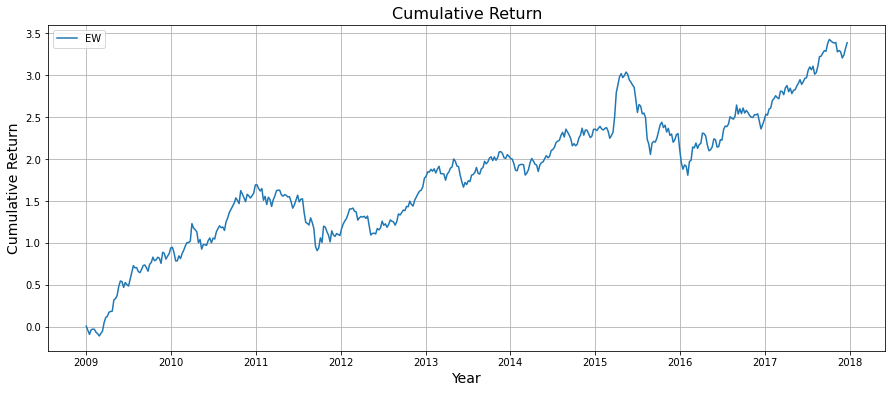

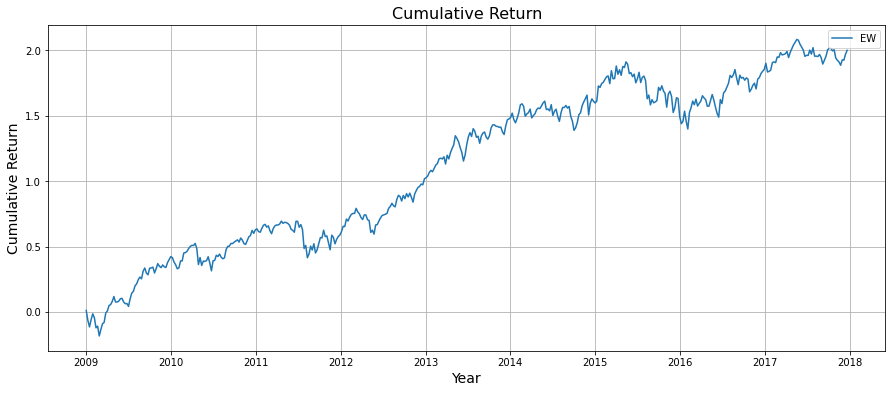

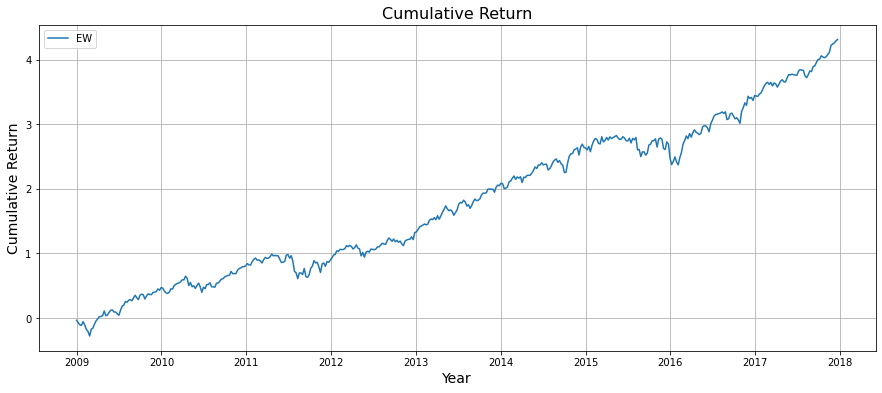

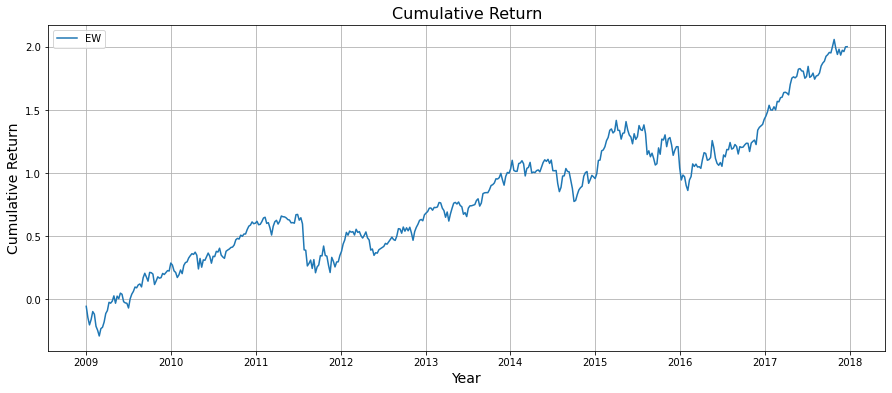

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


partition = 1/2
if partition == 1/3:
    ESTIMATION_START = 313
elif partition == 1/2:
    ESTIMATION_START = 469
elif partition == 2/3:
        ESTIMATION_START = 625
ESTIMATION_END = 938
ANNUAL_MULTIPLIER = np.sqrt(938/18)

for dataset in ['HSCI', 'FTSE', 'SP500', 'HDAX']:
    print('\nEW\n'
        f'Dataset: {dataset}\n'
        f'Partition: {partition}')

    # +1 to perform inclusive slicing
    data = pd.read_csv(f'data/wk_price_{dataset}.txt', sep="   ", header=None, engine='python').iloc[:ESTIMATION_END+1]

    RISK_FREE = pd.read_csv(f'data/rf_00_17.txt', header=None, engine='python').T[0]
    RISK_FREE = RISK_FREE.iloc[ESTIMATION_START:ESTIMATION_END+1]
    returns = (data / data.shift(1) - 1.)

    x = np.ones(data.shape[1])/data.shape[1]
    portfolio_returns = (
        returns[ESTIMATION_START:].shift(-1)@x
        ).loc[:ESTIMATION_END-1]

    excess_portfolio_returns = portfolio_returns - RISK_FREE
    R = excess_portfolio_returns.mean()

    # Sharpe
    SR = ANNUAL_MULTIPLIER*R/np.sqrt(
        np.sum((excess_portfolio_returns - R)**2)/(len(portfolio_returns)-1)
    )
    print(f'Sharpe: {SR:.4f}')

    # Sortino
    excess_portfolio_returns_dsr = excess_portfolio_returns.copy()
    excess_portfolio_returns_dsr[excess_portfolio_returns_dsr > 0] = 0
    DSR = np.sum(excess_portfolio_returns_dsr**2)/len(excess_portfolio_returns_dsr)
    print(f'Sortino: {ANNUAL_MULTIPLIER*R/np.sqrt(DSR):.4f}')
    # returns

    portfolio_returns += 1
    cumulative_returns = portfolio_returns.cumprod() - 1
    print(f'Cumulative return: {cumulative_returns.iloc[-1]:.4f}')

    fig = plt.figure(figsize=(15, 6))

    ax = plt.gca()

    dates = []
    date_start = datetime.datetime.strptime("2009-01-01","%Y-%m-%d")
    for i in range(len(cumulative_returns)):
        dates.append(date_start + datetime.timedelta(weeks=1*i))

    ax.plot(dates, cumulative_returns, label='EW')
    ax.set_title('Cumulative Return', fontsize=16)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Cumulative Return', fontsize=14)
    ax.legend()
    ax.grid()

%reset -f

In [ ]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


dataset = "HSCI"
partition = 1/2
ESTIMATION_END = 938
ANNUAL_MULTIPLIER = np.sqrt(938/18)

# print('EW\n'
#       f'Dataset: {dataset}\n'
#       f'Partition: {partition}')

# +1 to perform inclusive slicing
data = pd.read_csv(f'data/wk_price_{dataset}.txt', sep="   ", header=None, engine='python').iloc[:ESTIMATION_END+1]
print(data.shape[1])

%reset -f

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(25, 12))
plt.plot(np.sin(np.array([i for i in range(1, 10001)])), 'o', markersize=2)
plt.grid()

%reset -f

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

gamma = 1
r = np.array([
    [7, 8, 5],
    [4, 9, 1]
    ])
x = np.array([1, 1, 1])
rf = 1
mu = [2, 3, 4]
excess_r = r @ x - rf
temp = excess_r[excess_r > 0] = 0
temp = (temp)**2
risk = np.mean(temp)

f = (gamma**2)/2 * risk - gamma*(mu @ x - rf)

print(f)
%reset -f

### Run Index Simulation

In [22]:
import numpy as np
import pandas as pd
from pymongo import MongoClient


client = MongoClient(host="localhost", port=27017)
db = client.cno
runs = db.runs

objectives = ['SR', 'SoR']
datasets = ['DJIA', 'NASDAQ100', 'FTSE100', 'SP500_new']

NOTE = 'main'
partition = 1/2

for objective in objectives:
    for dataset in datasets:

        if dataset in ['FTSE', 'HSCI', 'HDAX', 'SP500']:
            ANNUAL_MULTIPLIER = np.sqrt(938/18)
        elif dataset == 'DJIA':
            ANNUAL_MULTIPLIER = np.sqrt(1362/26.25)
        elif dataset == 'NASDAQ100':
            ANNUAL_MULTIPLIER = np.sqrt(596/11.5)
        elif dataset == 'FTSE100':
            ANNUAL_MULTIPLIER = np.sqrt(716/13.83)
        elif dataset == 'SP500_new':
            ANNUAL_MULTIPLIER = np.sqrt(594/11.5)
        elif dataset == 'NASDAQComp':
            ANNUAL_MULTIPLIER = np.sqrt(684/13.25)

        RISK_FREE = pd.read_csv(f'data/rf_{dataset}.txt', header=None, engine='python').T[0]
        T = len(RISK_FREE)
        if T % 2 == 1:
            T -= 1
        ESTIMATION_START = T//2
        ESTIMATION_END = T
        index = [f'Week {i}' for i in range(T+1)]
        RISK_FREE = RISK_FREE.iloc[:ESTIMATION_END]
        xls = pd.ExcelFile(f'data/{dataset}.xlsx')
        index_returns = pd.read_excel(xls, 'Index_Returns', index_col=None, header=None)[0].iloc[:ESTIMATION_END]
        index_returns = index_returns.iloc[ESTIMATION_START:ESTIMATION_END]
        excess_index_returns = index_returns - RISK_FREE.iloc[ESTIMATION_START:ESTIMATION_END]

        index_reference = [np.nan]*len(excess_index_returns)
        if objective == 'SR':
            for i in range(len(excess_index_returns)):
                if i == 0: continue
                eir_slice = excess_index_returns.copy()[:i+1]
                R = eir_slice.mean()
                index_reference[i] = R/np.sqrt(
                    np.sum((eir_slice - R)**2)/(len(eir_slice)-1)
                )
        elif objective == 'SoR':
            for i in range(len(excess_index_returns)):
                if i == 0: continue
                eir_slice = excess_index_returns.copy()[:i+1]
                R = eir_slice.mean()
                eir_slice[eir_slice>0] = 0
                index_reference[i] = R/np.sqrt(
                    np.sum(eir_slice**2)/len(eir_slice)
                )
        index_reference = [ANNUAL_MULTIPLIER*elem for elem in index_reference]
        index_returns =index_returns + 1
        cumulative_product = np.nancumprod(index_returns)
        annualized_returns = np.power(cumulative_product, 1/9) - 1

        object = {
            "note": NOTE,
            "objective": objective,
            "dataset": dataset,
            "data_partition": partition,
            "rebalancing_rule": "INDEX",
            "metric_seq": index_reference,
            "metric": index_reference[-1],
            "annualized_returns": annualized_returns.tolist(),
            "ESTIMATION_START": ESTIMATION_START,
            "ESTIMATION_END": ESTIMATION_END,
        }

        if runs.find_one(object) is None:
            runs.insert_one(object)
            print(
                f'{objective} {dataset}\n'
                f'{objective}: {index_reference[-1]:.4f}\n'
                f'Annualized return: {annualized_returns[-1]:.4f}\n'
            )
        else:
            print('Duplicate found!')

%reset -f

Duplicate found!
Duplicate found!
Duplicate found!
Duplicate found!


/tmp/ipykernel_291931/2945975487.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  index_reference[i] = R/np.sqrt(
/tmp/ipykernel_291931/2945975487.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  index_reference[i] = R/np.sqrt(


Duplicate found!
Duplicate found!
Duplicate found!
Duplicate found!


/tmp/ipykernel_291931/2945975487.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  index_reference[i] = R/np.sqrt(


In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient
from matplotlib.ticker import MaxNLocator


pd.set_option("display.precision", 4)

client = MongoClient(host="localhost", port=27017)
db = client.cno
runs = db.runs

objectives = ['SR', 'SoR']
datasets = ['HSCI', 'FTSE', 'HDAX', 'SP500']
partition = 1/2
NOTE = '24.06.22'
ANNUAL_MULTIPLYER = np.sqrt(938/18)
ESTIMATION_START = 469

for objective in objectives:
    for dataset in datasets:

        filters = {
            'objective': objective,
            'dataset': dataset,
            'data_partition': partition,
            'note': NOTE,
        }

        filters['rebalancing_rule'] = 'DISABLE'
        ew_doc = runs.find_one(filters)

        filters['rebalancing_rule'] = 'INDEX'
        index_doc = runs.find_one(filters)

        filters['rebalancing_rule'] = 'PERIODIC'
        every_week_doc = runs.find_one(filters)

        filters['rebalancing_rule'] = 'EVENT'
        event_doc = list(runs.find(filters).sort('metric', -1).limit(1))[0]

        dates = []
        date_start = datetime.datetime.strptime("2009-01-01","%Y-%m-%d")
        for i in range(len(ew_doc['metric_seq'])):
            dates.append(date_start + datetime.timedelta(weeks=1*i))

        fig = plt.figure(figsize=(10, 5))
        ax = plt.gca()
        weeks_skip = 40
        ax.plot(dates[weeks_skip:], [ANNUAL_MULTIPLYER*e for e in  ew_doc['metric_seq'][weeks_skip:]], label='Equally-weighted')
        ax.plot(dates[weeks_skip:], [ANNUAL_MULTIPLYER*e for e in  event_doc['metric_seq'][weeks_skip:]], linewidth=3, label='Event-triggered rebalancing')
        ax.plot(dates[weeks_skip:], [ANNUAL_MULTIPLYER*e for e in  every_week_doc['metric_seq'][weeks_skip:]], label='Every-week rebalancing')
        ax.plot(dates[weeks_skip:], [ANNUAL_MULTIPLYER*e for e in  index_doc['metric_seq'][weeks_skip:]], label='Market Index')
        ax.set_xlabel('Year', fontsize=18)
        ax.set_ylabel('Sharpe Ratio' if objective == 'SR' else 'Sortino Ratio', fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.legend(fontsize=18)
        plt.title(dataset, fontsize=20)
        plt.savefig(f'results/expost_{objective}_{dataset}.eps')

%reset -f

IndexError: list index out of range

In [2]:
import numpy as np
import pandas as pd

dataset = 'HSCI'
ESTIMATION_END = 938
data = pd.read_csv(f'data/wk_price_{dataset}.txt', sep="   ", header=None, engine='python').iloc[:ESTIMATION_END+1]
# data = pd.read_excel(f'BCST-Lib/Datasets/DowJones/DowJones.xlsx', index_col=None, header=None).iloc[:ESTIMATION_END+1]
columns = [f'Asset {i}' for i in range(data.shape[1])]
data.columns = columns
index = [f'Week {i}' for i in range(data.shape[0])]
data.index = index
print(data)
%reset -f

            Asset 0    Asset 1    Asset 2   Asset 3    Asset 4    Asset 5  \
Week 0     4.235333   3.435218   2.613997  1.243917  219.64259   1.217692   
Week 1     4.305531   3.435218   2.484377  1.362385  202.17104   1.135830   
Week 2     3.977937   3.363651   2.484377  1.322896  202.17104   1.282235   
Week 3     4.001336   3.256300   2.484377  1.461109  202.17104   1.220192   
Week 4     3.790740   2.934248   2.354757  1.461109  202.17104   1.199511   
...             ...        ...        ...       ...        ...        ...   
Week 934  33.852760  10.520629  10.773824  5.376206    3.05000  36.550148   
Week 935  33.892914  10.349405  10.191906  5.262624    2.85000  34.360508   
Week 936  32.447243  10.406479  10.474551  5.300485    3.30000  33.728878   
Week 937  32.929134  10.805998  10.125400  5.414067    3.75000  34.444725   
Week 938  33.290550  11.034293  10.108772  5.527649    3.65000  35.581650   

            Asset 6    Asset 7    Asset 8   Asset 9  ...  Asset 67  Asset 6

In [ ]:
import numpy as np
import pandas as pd
from pymongo import MongoClient


client = MongoClient(host="localhost", port=27017)
db = client.cno
runs = db.runs

object = {
            "note": 'main',
            "objective": objective,
            "dataset": 'DJIA',
            "data_partition": 1/2,
            "rebalancing_rule": "INDEX",
            "annualized_returns": annualized_returns.tolist(),
            "ESTIMATION_START": ESTIMATION_START,
        }

        if runs.find_one(object) is None:
            runs.insert_one(object)
            print(
                f'{objective} {dataset}\n'
                f'{objective}: {index_reference[-1]:.4f}\n'
                f'Annualized return: {annualized_returns[-1]:.4f}\n'
            )

%reset -f